# LoRA on MNIST  
This notebook will attempt to implement Low-Rank Adaptation(LoRA) Finetuning from scratch on the MNIST dataset using pytorch lightning. I'm purposely using a simple model and data that way I can focus on LoRA implementation. 

Plan
1. Build an MLP. Train this model to perform well on MNIST 0-4 (half of the data).
3. Use standard finetuning approach to train this model to work on MNIST 5-9 (this will act as our baseline)
4. Use LoRA finetuning to train the original model to work on MNIST 5-9
5. Compare finetuning techniques (performance, memory etc)


Sources:
1. https://arxiv.org/abs/2106.09685 - LoRA paper
2. https://lightning.ai/pages/community/tutorial/lora-llm/ - (The first half offers useful starter pseudocode)
3. https://colab.research.google.com/drive/1iERDk94Jp0UErsPf7vXyPKeiM4ZJUQ-a?usp=sharing#scrollTo=WuK0lPwcB7Ia - had some good ideas on metrics to compute about LoRA-ized model
4. https://lightning.ai/docs/pytorch/stable/notebooks/lightning_examples/mnist-hello-world.html - starter code for building an MLP and training on MNIST
5. https://discuss.pytorch.org/t/how-to-use-one-class-of-number-in-mnist/26276/21 - forum post on how to limit MNIST to only first or second half

In [ ]:
import lightning as L
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import LearningRateFinder
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from pytorch_lightning import Callback
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

from torchmetrics import Accuracy

import pandas as pd
import seaborn as sn
import math
import matplotlib.pyplot as plt

# set precision to what lightning suggests for this gpu
torch.set_float32_matmul_precision('high')
# make results reproducible
L.seed_everything(42)

/home/mrigankp/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42


42

KeyboardInterrupt: 

In [ ]:
# reserved for constants
PATH_DATASETS = 'mnist'

In [ ]:
# Create another dataset called "quantized_mnist" where feature values are rounded to 0 or 255

class QuantizedMNIST(MNIST):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Lambda(lambda x: torch.round(x)),
            ]
        )

In [ ]:
# Create another dataset called "inversecolor_mnist" where all pixel values are inverted
# class InverseColorMNIST(MNIST):
#     def __init__(self, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.transform = transforms.Compose(
#             [
#                 transforms.ToTensor(),
#                 transforms.Lambda(lambda x: 1 - x),
#             ]
#         )
        
# Create another dataset called "inverted_mnist" where all images are rotated by 180 degrees
class InvertedMNIST(MNIST):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Lambda(lambda x: x.rot90(2, [1, 2])),
            ]
        )

Train an MLP on full MNIST

In [ ]:
class LitMNIST(L.LightningModule):
    def __init__(self, data_dir=PATH_DATASETS, hidden_size=64, lr=2e-4, ver='n'):
        """
        'ver' is 'n' for normal mnist, 'q' for quantized mnist
        """
        super().__init__()
        
        self.version = ver

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.lr = lr

        # Hardcode some dataset specific attributes
        self.class_names = [0,1,2,3,4,5,6,7,8,9]
        self.min_class = min(self.class_names)
        self.num_classes = len(self.class_names) 
        self.dims = (1, 28, 28) # the shape of an example (C x W x H)
        channels, width, height = self.dims

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        self.batch_size = 1024

        # Define layers for model
        self.l1 = nn.Linear(channels * width * height, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, self.num_classes)

        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()

        
        # Define metrics
        self.val_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)


    def forward(self, x):
        # preprocessing
        x = torch.flatten(x,1)

        # layer 1 (input size, hidden size)
        x = self.l1(x)
        x = self.relu(x)
        x = self.dropout(x)

        # layer 2 (hidden size, hidden size)
        x = self.l2(x)
        x = self.relu(x)
        x = self.dropout(x)

        #layer 3 (hidden size, self.num_classes)
        x = self.l3(x)
                    
        # notice that we return the log probabilities here as that is what nll loss expects in the training step
        return F.log_softmax(x, dim=1)

    def common_step(self, batch, batch_idx):
        # define steps all of {train, val, test} will take in one place
        x, y = batch
        # rescale y to be 0 indexed if necessary (like when we start using mnist 5-9)
        if self.min_class != 0:
            y = y - self.min_class
        
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return x,y, logits, loss
        
        

    def training_step(self, batch, batch_idx):
        _, _, _, loss = self.common_step(batch, batch_idx)
        self.log("train_loss", loss, batch_size=self.batch_size)
        return loss

    def validation_step(self, batch, batch_idx):
        
        x, y, logits, loss = self.common_step(batch, batch_idx)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y, logits, loss = self.common_step(batch, batch_idx)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)
    
    def configure_optimizers(self):
        # we'll use adamw to match the paper
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        return optimizer

    # the rest of the class is helper functions/hooks for configuring data/dataloader building
    @staticmethod
    def get_indices(dataset,class_names):
        if isinstance(dataset, torch.utils.data.dataset.Subset):
            targets = torch.tensor([dataset.dataset.targets[i] for i in dataset.indices])
        else:
            targets = dataset.targets

            
        indices =  []
        for i in range(len(targets)):
            if targets[i] in class_names:
                indices.append(i)
        return indices
        
    def create_dataloader(self,dataset):
        idx = self.get_indices(dataset, self.class_names)
        loader = DataLoader(dataset,batch_size=self.batch_size, sampler = SubsetRandomSampler(idx), num_workers=16) # Note - this necessarily shuffles the data due to the sampler we are using
        return loader

    def prepare_data(self):
        # download data
        if self.version == 'n':
            MNIST(self.data_dir, train=True, download=True)
            MNIST(self.data_dir, train=False, download=True)
        if self.version == 'q':
            print("Checkpoint-(0)")
            QuantizedMNIST(self.data_dir, train=True, download=True)
            QuantizedMNIST(self.data_dir, train=False, download=True)
        if self.version == 'i':
            print("Checkpoint-(10)")
            InvertedMNIST(self.data_dir, train=True, download=True)
            InvertedMNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if self.version == 'n':
            if stage == "fit" or stage is None:
                mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
                self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])
        if self.version == 'q':
            print("Checkpoint-(1)")
            if stage == "fit" or stage is None:
                mnist_full = QuantizedMNIST(self.data_dir, train=True, transform=self.transform)
                self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])
        if self.version == 'i':
            print("Checkpoint-(11)")
            if stage == "fit" or stage is None:
                mnist_full = InvertedMNIST(self.data_dir, train=True, transform=self.transform)
                self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

            

        # Assign test dataset for use in dataloader(s)
        if self.version == 'n':
            if stage == "test" or stage is None:
                self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)
        if self.version == 'q':
            if stage == "test" or stage is None:
                self.mnist_test = QuantizedMNIST(self.data_dir, train=False, transform=self.transform)   
        if self.version == 'i':
            if stage == "test" or stage is None:
                self.mnist_test = InvertedMNIST(self.data_dir, train=False, transform=self.transform)            

    def train_dataloader(self):
        return self.create_dataloader(self.mnist_train)

    def val_dataloader(self):
        return self.create_dataloader(self.mnist_val)

    def test_dataloader(self):
        return self.create_dataloader(self.mnist_test)
    
    def predict(self, x):
        logits = self(x)
        return torch.argmax(logits, dim=1)


In [ ]:
model = LitMNIST()
trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=10,
    logger=CSVLogger(save_dir="logs/"),
)
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 50.2 K
1 | l2            | Linear             | 4.2 K 
2 | l3            | Linear             | 650   
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
-----------------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.220     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 54/54 [00:01<00:00, 29.93it/s, v_num=6, val_loss=0.248, val_acc=0.928]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 54/54 [00:01<00:00, 29.86it/s, v_num=6, val_loss=0.248, val_acc=0.928]


,train_loss,val_acc,val_loss
epoch,,,
0,1.533384,NaN,NaN
0,NaN,0.7104,1.366489
1,0.808736,NaN,NaN
1,NaN,0.8364,0.680481
2,0.596579,NaN,NaN


/home/mrigankp/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


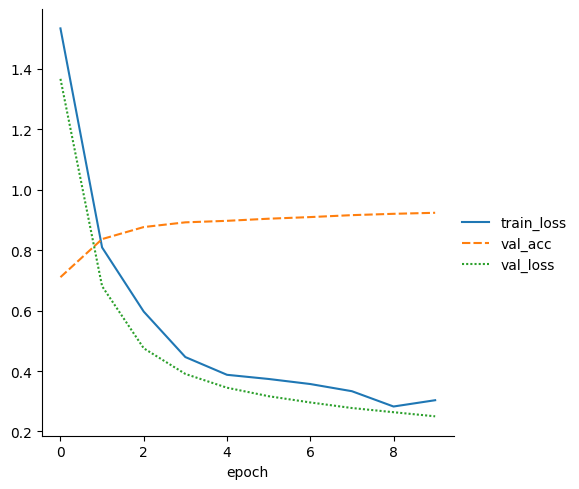

In [ ]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

In [ ]:
# as expected our model performs well
trainer.test()

Restoring states from the checkpoint path at logs/lightning_logs/version_6/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/lightning_logs/version_6/checkpoints/epoch=9-step=540.ckpt


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 202.64it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9311000108718872     │
│         test_loss         │    0.2292446345090866     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.2292446345090866, 'test_acc': 0.9311000108718872}]

In [ ]:
# save model weights so we can finetune from them later
trainer.save_checkpoint("model.ckpt")
torch.save(model.state_dict(), 'model.pt')

# Finetune on Quantized MNIST and Inverted MNIST

In [ ]:
# create the dataset
quantized_mnist = QuantizedMNIST(PATH_DATASETS, train=True, download=True)

# create a dataloader
quantized_mnist_loader = DataLoader(quantized_mnist, batch_size=1024, shuffle=False)

In [ ]:
# test the accuracy of the model on entire quantized dataset
acc = 0
for x, y in quantized_mnist_loader:
    preds = model.predict(x)
    acc += torch.sum(preds == y).item()
    
acc /= len(quantized_mnist)

print(acc)

0.8455833333333334


In [ ]:
# create the dataset
inverted_mnist = InvertedMNIST(PATH_DATASETS, train=True, download=True)

# create a dataloader
inverted_mnist_loader = DataLoader(inverted_mnist, batch_size=1024, shuffle=False)

In [ ]:
# test the accuracy of the model on entire quantized dataset
acc = 0
for x, y in inverted_mnist_loader:
    preds = model.predict(x)
    acc += torch.sum(preds == y).item()
    
acc /= len(quantized_mnist)

print(acc)

0.1484


In [ ]:
# now finetune e2e on the new data
model_quantized = LitMNIST.load_from_checkpoint(checkpoint_path="model.ckpt")
model_quantized.version = 'q'

trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=10,
    logger=CSVLogger(save_dir="logs/"),
)
trainer.fit(model_quantized)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 50.2 K
1 | l2            | Linear             | 4.2 K 
2 | l3            | Linear             | 650   
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
-----------------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.220     Total estimated model params size (MB)


Checkpoint-(0)
Checkpoint-(1)
Epoch 9: 100%|██████████| 54/54 [00:01<00:00, 33.99it/s, v_num=8, val_loss=0.236, val_acc=0.934]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 54/54 [00:01<00:00, 33.89it/s, v_num=8, val_loss=0.236, val_acc=0.934]


In [ ]:
# now finetune e2e on the new data
model_inverted = LitMNIST.load_from_checkpoint(checkpoint_path="model.ckpt")
model_inverted.version = 'i'

trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=10,
    logger=CSVLogger(save_dir="logs/"),
)
trainer.fit(model_inverted)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Checkpoint-(10)
Checkpoint-(11)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 50.2 K
1 | l2            | Linear             | 4.2 K 
2 | l3            | Linear             | 650   
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
-----------------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.220     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 54/54 [00:01<00:00, 34.26it/s, v_num=9, val_loss=0.280, val_acc=0.922]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 54/54 [00:01<00:00, 34.16it/s, v_num=9, val_loss=0.280, val_acc=0.922]


# Finetune on quantized MNIST using LoRA

In [ ]:
class LitMNISTLoRA(L.LightningModule):
    def __init__(self, data_dir=PATH_DATASETS, hidden_size=64, lr=2e-4, lora_rank = 8):
        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.lr = lr

        # Hardcode some dataset specific attributes
        self.class_names = [0,1,2,3,4,5,6,7,8,9]
        self.min_class = min(self.class_names)
        self.num_classes = len(self.class_names) 
        self.dims = (1, 28, 28) # the shape of an example (C x W x H)
        channels, width, height = self.dims

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        self.batch_size = 1024 # 64
        
        # Define layers for model
        self.l1 = nn.Linear(channels * width * height, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, self.num_classes)

        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()

        # Define lora hyperparameters
        self.lora_rank = lora_rank # The rank 'r' for the low-rank adaptation
        self.lora_alpha = 1 # lora scaling factor
        
        # layer 1 lora layers
        self.l1_lora_A = nn.Parameter(torch.empty(channels * width * height, self.lora_rank))
        self.l1_lora_B = nn.Parameter(torch.empty(self.lora_rank, hidden_size))

        # layer 2 lora layers
        self.l2_lora_A =  nn.Parameter(torch.empty(hidden_size, self.lora_rank))
        self.l2_lora_B = nn.Parameter(torch.empty(self.lora_rank, hidden_size))

        # layer 3 lora layers
        self.l3_lora_A = nn.Parameter(torch.empty(hidden_size, self.lora_rank))
        self.l3_lora_B = nn.Parameter(torch.empty(self.lora_rank, self.num_classes))
        
        # Define initialization for lora layers (this ensures that the model behavior is identital to to the original model prior to finetuning)
        for n,p in self.named_parameters():
            if 'lora' in n:
                if n[-1]=='A':
                    nn.init.kaiming_uniform_(p, a=math.sqrt(5))
                elif n[-1]=='B':
                    nn.init.zeros_(p)

        # freeze non lora weights
        for n,p in self.named_parameters():
            if 'lora' not in n:
                p.requires_grad = False
        
        # Define metrics
        self.val_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)


    def lora_linear(self, x, layer, lora_A, lora_B):
        # does the work of combining outputs from normal layer and lora layer for x
        # notice that h is the sum of two separate operations on x
        h = layer(x)
        h += x@(lora_A @ lora_B)*self.lora_alpha
        return h
        
    def forward(self, x):
        # preprocessing
        x = torch.flatten(x,1)
        
        # layer 1 (input size, hidden size)
        x = self.lora_linear(x, self.l1, self.l1_lora_A, self.l1_lora_B)
        x = self.relu(x)
        x = self.dropout(x)

        # layer 2 (hidden size, hidden size)
        x = self.lora_linear(x, self.l2, self.l2_lora_A, self.l2_lora_B)
        x = self.relu(x)
        x = self.dropout(x)

        #layer 3 (hidden size, self.num_classes)
        x = self.lora_linear(x, self.l3, self.l3_lora_A, self.l3_lora_B)
                    
        # notice that we return the log probabilities here as that is what nll loss expects in the training step
        return F.log_softmax(x, dim=1)

    def common_step(self, batch, batch_idx):
        # define steps all of {train, val, test} will take in one place
        x, y = batch
        # rescale y to be 0 indexed if necessary (like when we start using mnist 5-9)
        if self.min_class != 0:
            y = y - self.min_class
        
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return x,y, logits, loss
        
        

    def training_step(self, batch, batch_idx):
        _, _, _, loss = self.common_step(batch, batch_idx)
        self.log("train_loss", loss, batch_size=self.batch_size)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, logits, loss = self.common_step(batch, batch_idx)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)

        self.log("val_loss", loss, prog_bar=False)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y, logits, loss = self.common_step(batch, batch_idx)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)
    
    def configure_optimizers(self):
        # we'll use adamw to match the paper
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

        return {
        "optimizer": optimizer,
        "lr_scheduler": {
            "scheduler": scheduler,
            "monitor": "val_loss",
            "frequency": 1
        },
        }

      
    # the rest of the class is helper functions/hooks for configuring data/dataloader building
    @staticmethod
    def get_indices(dataset,class_names):
        if isinstance(dataset, torch.utils.data.dataset.Subset):
            targets = torch.tensor([dataset.dataset.targets[i] for i in dataset.indices])
        else:
            targets = dataset.targets

            
        indices =  []
        for i in range(len(targets)):
            if targets[i] in class_names:
                indices.append(i)
        return indices
        
    def create_dataloader(self,dataset):
        idx = self.get_indices(dataset, self.class_names)
        loader = DataLoader(dataset,batch_size=self.batch_size, sampler = SubsetRandomSampler(idx), num_workers=16) # Note - this necessarily shuffles the data due to the sampler we are using
        return loader

    def prepare_data(self):
        # download data
        QuantizedMNIST(self.data_dir, train=True, download=True)
        QuantizedMNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_full = QuantizedMNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.mnist_test = QuantizedMNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return self.create_dataloader(self.mnist_train)

    def val_dataloader(self):
        return self.create_dataloader(self.mnist_val)

    def test_dataloader(self):
        return self.create_dataloader(self.mnist_test)

In [ ]:
# try lora finetuning with different lora ranks
def lora_experiment(rank):
    state_dict = torch.load("model.pt")
    model = LitMNISTLoRA(lora_rank=rank,)
    model.load_state_dict(state_dict, strict=False)
    
    from lightning.pytorch.callbacks import LearningRateMonitor
    lr_monitor = LearningRateMonitor(logging_interval='step')
    
    trainer = L.Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=10,
        callbacks=[lr_monitor, EarlyStopping(monitor="val_loss", mode="min", patience=10)],

        enable_progress_bar=False
    )
    
    trainer.fit(model)
    return trainer.test()[0]['test_acc']

# try lora full training with different lora ranks
def lora_experiment_fulltrain(rank):
    # state_dict = torch.load("model.pt")
    model = LitMNISTLoRA(lora_rank=rank,)
    # model.load_state_dict(state_dict, strict=False)
    
    from lightning.pytorch.callbacks import LearningRateMonitor
    lr_monitor = LearningRateMonitor(logging_interval='step')
    
    trainer = L.Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=10,
        callbacks=[lr_monitor, EarlyStopping(monitor="val_loss", mode="min", patience=10)],

        enable_progress_bar=False
    )
    
    trainer.fit(model)
    return trainer.test()[0]['test_acc']

In [ ]:
import time

results = {}
for rank in [1, 2, 4, 8, 16, 32, 64]:
    start_time = time.time()
    result = lora_experiment(rank)
    end_time = time.time()
    elapsed_time = end_time - start_time

    results[rank] = (result, elapsed_time)  # Store both accuracy and time
    print(f"Rank {rank} Accuracy: {result}, Time: {elapsed_time:.4f} seconds")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/mrigankp/.local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 50.2 K
1 | l2            | Linear             | 4.2 K 
2 | l3            | Linear             | 650   
3 | dropout       | Drop

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/lightning_logs/version_22/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/lightning_logs/version_22/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9063000082969666     │
│         test_loss         │    0.5468206405639648     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Rank 1 Accuracy: 0.9063000082969666, Time: 34.9063 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 50.2 K
1 | l2            | Linear             | 4.2 K 
2 | l3            | Linear             | 650   
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 2.1 K 
-----------------------------------------------------
2.1 K     Trainable params
55.1 K    Non-trainable params
57.1 K    Total params
0.229     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/lightning_logs/version_23/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weight

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.909500002861023     │
│         test_loss         │    0.48807552456855774    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Rank 2 Accuracy: 0.909500002861023, Time: 34.6526 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 50.2 K
1 | l2            | Linear             | 4.2 K 
2 | l3            | Linear             | 650   
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 4.2 K 
-----------------------------------------------------
4.2 K     Trainable params
55.1 K    Non-trainable params
59.2 K    Total params
0.237     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/lightning_logs/version_24/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weight

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9121999740600586     │
│         test_loss         │    0.41099658608436584    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Rank 4 Accuracy: 0.9121999740600586, Time: 25.2445 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 50.2 K
1 | l2            | Linear             | 4.2 K 
2 | l3            | Linear             | 650   
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 8.4 K 
-----------------------------------------------------
8.4 K     Trainable params
55.1 K    Non-trainable params
63.5 K    Total params
0.254     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/lightning_logs/version_25/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weight

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9133999943733215     │
│         test_loss         │    0.3427736759185791     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Rank 8 Accuracy: 0.9133999943733215, Time: 33.7363 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 50.2 K
1 | l2            | Linear             | 4.2 K 
2 | l3            | Linear             | 650   
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 16.8 K
-----------------------------------------------------
16.8 K    Trainable params
55.1 K    Non-trainable params
71.9 K    Total params
0.287     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/lightning_logs/version_26/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weight

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9199000000953674     │
│         test_loss         │    0.2971551716327667     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Rank 16 Accuracy: 0.9199000000953674, Time: 34.5702 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 50.2 K
1 | l2            | Linear             | 4.2 K 
2 | l3            | Linear             | 650   
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 33.6 K
-----------------------------------------------------
33.6 K    Trainable params
55.1 K    Non-trainable params
88.7 K    Total params
0.355     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/lightning_logs/version_27/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weight

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9253000020980835     │
│         test_loss         │    0.26633894443511963    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 50.2 K
1 | l2            | Linear             | 4.2 K 
2 | l3            | Linear             | 650   
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 67.2 K
-----------------------------------------------------
67.2 K    Trainable params
55.1 K    Non-trainable params
122 K     Total params
0.489     Total estimated model params size (MB)


Rank 32 Accuracy: 0.9253000020980835, Time: 24.8980 seconds


`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/lightning_logs/version_28/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/lightning_logs/version_28/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.930400013923645     │
│         test_loss         │    0.23627407848834991    │
└───────────────────────────┴───────────────────────────┘

Rank 64 Accuracy: 0.930400013923645, Time: 32.3039 seconds


In [ ]:
results

{1: (0.9063000082969666, 34.9062557220459),
 2: (0.909500002861023, 34.65264916419983),
 4: (0.9121999740600586, 25.24445414543152),
 8: (0.9133999943733215, 33.73633813858032),
 16: (0.9199000000953674, 34.570229053497314),
 32: (0.9253000020980835, 24.897957801818848),
 64: (0.930400013923645, 32.30386519432068)}

In [ ]:
# full training

results = {}
for rank in [1, 2, 4, 8, 16, 32, 64]:
    start_time = time.time()
    result = lora_experiment_fulltrain(rank)
    end_time = time.time()
    elapsed_time = end_time - start_time

    results[rank] = (result, elapsed_time)  # Store both accuracy and time
    print(f"Rank {rank} Accuracy: {result}, Time: {elapsed_time:.4f} seconds")

In [ ]:
class LitMNISTLoRA_Inverted(L.LightningModule):
    def __init__(self, data_dir=PATH_DATASETS, hidden_size=64, lr=2e-4, lora_rank = 8):
        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.lr = lr

        # Hardcode some dataset specific attributes
        self.class_names = [0,1,2,3,4,5,6,7,8,9]
        self.min_class = min(self.class_names)
        self.num_classes = len(self.class_names) 
        self.dims = (1, 28, 28) # the shape of an example (C x W x H)
        channels, width, height = self.dims

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        self.batch_size = 1024 # 64
        
        # Define layers for model
        self.l1 = nn.Linear(channels * width * height, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, self.num_classes)

        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()

        # Define lora hyperparameters
        self.lora_rank = lora_rank # The rank 'r' for the low-rank adaptation
        self.lora_alpha = 1 # lora scaling factor
        
        # layer 1 lora layers
        self.l1_lora_A = nn.Parameter(torch.empty(channels * width * height, self.lora_rank))
        self.l1_lora_B = nn.Parameter(torch.empty(self.lora_rank, hidden_size))

        # layer 2 lora layers
        self.l2_lora_A =  nn.Parameter(torch.empty(hidden_size, self.lora_rank))
        self.l2_lora_B = nn.Parameter(torch.empty(self.lora_rank, hidden_size))

        # layer 3 lora layers
        self.l3_lora_A = nn.Parameter(torch.empty(hidden_size, self.lora_rank))
        self.l3_lora_B = nn.Parameter(torch.empty(self.lora_rank, self.num_classes))
        
        # Define initialization for lora layers (this ensures that the model behavior is identital to to the original model prior to finetuning)
        for n,p in self.named_parameters():
            if 'lora' in n:
                if n[-1]=='A':
                    nn.init.kaiming_uniform_(p, a=math.sqrt(5))
                elif n[-1]=='B':
                    nn.init.zeros_(p)

        # freeze non lora weights
        for n,p in self.named_parameters():
            if 'lora' not in n:
                p.requires_grad = False
        
        # Define metrics
        self.val_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)


    def lora_linear(self, x, layer, lora_A, lora_B):
        # does the work of combining outputs from normal layer and lora layer for x
        # notice that h is the sum of two separate operations on x
        h = layer(x)
        h += x@(lora_A @ lora_B)*self.lora_alpha
        return h
        
    def forward(self, x):
        # preprocessing
        x = torch.flatten(x,1)
        
        # layer 1 (input size, hidden size)
        x = self.lora_linear(x, self.l1, self.l1_lora_A, self.l1_lora_B)
        x = self.relu(x)
        x = self.dropout(x)

        # layer 2 (hidden size, hidden size)
        x = self.lora_linear(x, self.l2, self.l2_lora_A, self.l2_lora_B)
        x = self.relu(x)
        x = self.dropout(x)

        #layer 3 (hidden size, self.num_classes)
        x = self.lora_linear(x, self.l3, self.l3_lora_A, self.l3_lora_B)
                    
        # notice that we return the log probabilities here as that is what nll loss expects in the training step
        return F.log_softmax(x, dim=1)

    def common_step(self, batch, batch_idx):
        # define steps all of {train, val, test} will take in one place
        x, y = batch
        # rescale y to be 0 indexed if necessary (like when we start using mnist 5-9)
        if self.min_class != 0:
            y = y - self.min_class
        
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return x,y, logits, loss
        
        

    def training_step(self, batch, batch_idx):
        _, _, _, loss = self.common_step(batch, batch_idx)
        self.log("train_loss", loss, batch_size=self.batch_size)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, logits, loss = self.common_step(batch, batch_idx)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)

        self.log("val_loss", loss, prog_bar=False)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y, logits, loss = self.common_step(batch, batch_idx)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)
    
    def configure_optimizers(self):
        # we'll use adamw to match the paper
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

        return {
        "optimizer": optimizer,
        "lr_scheduler": {
            "scheduler": scheduler,
            "monitor": "val_loss",
            "frequency": 1
        },
        }

      
    # the rest of the class is helper functions/hooks for configuring data/dataloader building
    @staticmethod
    def get_indices(dataset,class_names):
        if isinstance(dataset, torch.utils.data.dataset.Subset):
            targets = torch.tensor([dataset.dataset.targets[i] for i in dataset.indices])
        else:
            targets = dataset.targets

            
        indices =  []
        for i in range(len(targets)):
            if targets[i] in class_names:
                indices.append(i)
        return indices
        
    def create_dataloader(self,dataset):
        idx = self.get_indices(dataset, self.class_names)
        loader = DataLoader(dataset,batch_size=self.batch_size, sampler = SubsetRandomSampler(idx), num_workers=16) # Note - this necessarily shuffles the data due to the sampler we are using
        return loader

    def prepare_data(self):
        # download data
        InvertedMNIST(self.data_dir, train=True, download=True)
        InvertedMNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_full = InvertedMNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.mnist_test = InvertedMNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return self.create_dataloader(self.mnist_train)

    def val_dataloader(self):
        return self.create_dataloader(self.mnist_val)

    def test_dataloader(self):
        return self.create_dataloader(self.mnist_test)

In [ ]:
# try lora finetuning with different lora ranks
def lora_experiment_inverted(rank):
    state_dict = torch.load("model.pt")
    model = LitMNISTLoRA_Inverted(lora_rank=rank,)
    model.load_state_dict(state_dict, strict=False)
    
    from lightning.pytorch.callbacks import LearningRateMonitor
    lr_monitor = LearningRateMonitor(logging_interval='step')
    
    trainer = L.Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=10,
        callbacks=[lr_monitor, EarlyStopping(monitor="val_loss", mode="min", patience=10)],

        enable_progress_bar=False
    )
    
    trainer.fit(model)
    return trainer.test()[0]['test_acc']

In [ ]:
import time

results = {}
for rank in [1, 2, 4, 8, 16, 32, 64]:
    start_time = time.time()
    result = lora_experiment_inverted(rank)
    end_time = time.time()
    elapsed_time = end_time - start_time

    results[rank] = (result, elapsed_time)  # Store both accuracy and time
    print(f"Rank {rank} Accuracy: {result}, Time: {elapsed_time:.4f} seconds")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 50.2 K
1 | l2            | Linear             | 4.2 K 
2 | l3            | Linear             | 650   
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 1.1 K 
-----------------------------------------------------
1.1 K     Trainable params
55.1 K    Non-trainable params
56.1 K    Total params
0.224     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 2

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4456999897956848     │
│         test_loss         │    1.6841665506362915     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 50.2 K
1 | l2            | Linear             | 4.2 K 
2 | l3            | Linear             | 650   
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 2.1 K 
-----------------------------------------------------
2.1 K     Trainable params
55.1 K    Non-trainable params
57.1 K    Total params
0.229     Total estimated model params size (MB)


Rank 1 Accuracy: 0.4456999897956848, Time: 18.9595 seconds


`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_37/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_37/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6279000043869019     │
│         test_loss         │     1.308717131614685     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 50.2 K
1 | l2            | Linear             | 4.2 K 
2 | l3            | Linear             | 650   
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 4.2 K 
-----------------------------------------------------
4.2 K     Trainable params
55.1 K    Non-trainable params
59.2 K    Total params
0.237     Total estimated model params size (MB)


Rank 2 Accuracy: 0.6279000043869019, Time: 17.5632 seconds


`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_38/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_38/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7168999910354614     │
│         test_loss         │    0.9004978537559509     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 50.2 K
1 | l2            | Linear             | 4.2 K 
2 | l3            | Linear             | 650   
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 8.4 K 
-----------------------------------------------------
8.4 K     Trainable params
55.1 K    Non-trainable params
63.5 K    Total params
0.254     Total estimated model params size (MB)


Rank 4 Accuracy: 0.7168999910354614, Time: 18.0514 seconds


`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_39/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_39/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8108000159263611     │
│         test_loss         │    0.6273475885391235     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 50.2 K
1 | l2            | Linear             | 4.2 K 
2 | l3            | Linear             | 650   
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 16.8 K
-----------------------------------------------------
16.8 K    Trainable params
55.1 K    Non-trainable params
71.9 K    Total params
0.287     Total estimated model params size (MB)


Rank 8 Accuracy: 0.8108000159263611, Time: 17.4117 seconds


`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_40/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_40/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8616999983787537     │
│         test_loss         │    0.4581376016139984     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 50.2 K
1 | l2            | Linear             | 4.2 K 
2 | l3            | Linear             | 650   
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 33.6 K
-----------------------------------------------------
33.6 K    Trainable params
55.1 K    Non-trainable params
88.7 K    Total params
0.355     Total estimated model params size (MB)


Rank 16 Accuracy: 0.8616999983787537, Time: 17.1165 seconds


`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_41/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_41/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8906999826431274     │
│         test_loss         │    0.36336445808410645    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 50.2 K
1 | l2            | Linear             | 4.2 K 
2 | l3            | Linear             | 650   
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 67.2 K
-----------------------------------------------------
67.2 K    Trainable params
55.1 K    Non-trainable params
122 K     Total params
0.489     Total estimated model params size (MB)


Rank 32 Accuracy: 0.8906999826431274, Time: 16.9832 seconds


`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_42/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_42/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9096999764442444     │
│         test_loss         │    0.2992924451828003     │
└───────────────────────────┴───────────────────────────┘

Rank 64 Accuracy: 0.9096999764442444, Time: 17.4064 seconds


In [ ]:
results

{1: (0.4456999897956848, 18.95950484275818),
 2: (0.6279000043869019, 17.563158988952637),
 4: (0.7168999910354614, 18.05138874053955),
 8: (0.8108000159263611, 17.411713361740112),
 16: (0.8616999983787537, 17.116520881652832),
 32: (0.8906999826431274, 16.983154296875),
 64: (0.9096999764442444, 17.40639615058899)}

In [ ]:
# test the accuracy of the model on original mnist dataset
# create the dataset
og_mnist = QuantizedMNIST(PATH_DATASETS, train=True, download=True)

# create a dataloader
og_mnist_loader = DataLoader(og_mnist, batch_size=1024, shuffle=False)

acc = 0
for x, y in og_mnist_loader:
    preds = model_inverted.predict(x)
    acc += torch.sum(preds == y).item()
    
acc /= len(og_mnist)

print(acc)

0.2637833333333333


# Full Training with LoRA

In [ ]:
import lte

for r in [1, 2, 4, 8, 16, 32, 64]:
      model = lte.prepare_model_for_lte(
            LitMNIST().cuda(),
            lte.LTEConfig.default(
                  lora_r=r,
                  lora_alpha=4096,
                  num_heads=1,
            ),
      )
      trainer = L.Trainer(
            accelerator="auto",
            devices=1,
            max_epochs=10,
            logger=CSVLogger(save_dir="logs/"),
      )
      print(f"TRAINING WITH RANK {r}")
      trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | l1            | MultiheadLoRALinear | 51.9 K
1 | l2            | MultiheadLoRALinear | 4.4 K 
2 | l3            | MultiheadLoRALinear | 798   
3 | dropout       | Dropout             | 0     
4 | relu          | ReLU                | 0     
5 | val_accuracy  | MulticlassAccuracy  | 0     
6 | test_accuracy | MulticlassAccuracy  | 0     
------------------------------------------------------
1.1 K     Trainable params
56.1 K    Non-trainable params
57.1 K    Total params
0.229     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 54/54 [00:03<00:00, 17.49it/s, v_num=10, val_loss=2.310, val_acc=0.083]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 54/54 [00:03<00:00, 17.38it/s, v_num=10, val_loss=2.310, val_acc=0.083]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | l1            | MultiheadLoRALinear | 53.6 K
1 | l2            | MultiheadLoRALinear | 4.7 K 
2 | l3            | MultiheadLoRALinear | 946   
3 | dropout       | Dropout             | 0     
4 | relu          | ReLU                | 0     
5 | val_accuracy  | MulticlassAccuracy  | 0     
6 | test_accuracy | MulticlassAccuracy  | 0     
------------------------------------------------------
2.1 K     Trainable params
57.1 K    Non-trainable params
59.2 K    Total params
0.237     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 54/54 [00:01<00:00, 37.97it/s, v_num=11, val_loss=2.320, val_acc=0.107]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 54/54 [00:01<00:00, 37.87it/s, v_num=11, val_loss=2.320, val_acc=0.107]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | l1            | MultiheadLoRALinear | 57.0 K
1 | l2            | MultiheadLoRALinear | 5.2 K 
2 | l3            | MultiheadLoRALinear | 1.2 K 
3 | dropout       | Dropout             | 0     
4 | relu          | ReLU                | 0     
5 | val_accuracy  | MulticlassAccuracy  | 0     
6 | test_accuracy | MulticlassAccuracy  | 0     
------------------------------------------------------
4.2 K     Trainable params
59.2 K    Non-trainable params
63.5 K    Total params
0.254     Total estimated model params size (MB)



Epoch 9: 100%|██████████| 54/54 [00:03<00:00, 15.12it/s, v_num=12, val_loss=2.300, val_acc=0.145]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 54/54 [00:03<00:00, 15.09it/s, v_num=12, val_loss=2.300, val_acc=0.145]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | l1            | MultiheadLoRALinear | 63.8 K
1 | l2            | MultiheadLoRALinear | 6.2 K 
2 | l3            | MultiheadLoRALinear | 1.8 K 
3 | dropout       | Dropout             | 0     
4 | relu          | ReLU                | 0     
5 | val_accuracy  | MulticlassAccuracy  | 0     
6 | test_accuracy | MulticlassAccuracy  | 0     
------------------------------------------------------
8.4 K     Trainable params
63.5 K    Non-trainable params
71.9 K    Total params
0.287     Total estimated model params size (MB)


/home/mrigankp/.local/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | l1            | MultiheadLoRALinear | 77.4 K
1 | l2            | MultiheadLoRALinear | 8.3 K 
2 | l3            | MultiheadLoRALinear | 3.0 K 
3 | dropout       | Dropout             | 0     
4 | relu          | ReLU                | 0     
5 | val_accuracy  | MulticlassAccuracy  | 0     
6 | test_accuracy | MulticlassAccuracy  | 0     
------------------------------------------------------
16.8 K    Trainable params
71.9 K    Non-trainable params
88.7 K    Total params
0.355     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 54/54 [00:03<00:00, 17.82it/s, v_num=14, val_loss=2.330, val_acc=0.093]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 54/54 [00:03<00:00, 17.78it/s, v_num=14, val_loss=2.330, val_acc=0.093]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | l1            | MultiheadLoRALinear | 104 K 
1 | l2            | MultiheadLoRALinear | 12.4 K
2 | l3            | MultiheadLoRALinear | 5.4 K 
3 | dropout       | Dropout             | 0     
4 | relu          | ReLU                | 0     
5 | val_accuracy  | MulticlassAccuracy  | 0     
6 | test_accuracy | MulticlassAccuracy  | 0     
------------------------------------------------------
33.6 K    Trainable params
88.7 K    Non-trainable params
122 K     Total params
0.489     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 54/54 [00:03<00:00, 17.22it/s, v_num=15, val_loss=2.310, val_acc=0.0886]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 54/54 [00:03<00:00, 17.16it/s, v_num=15, val_loss=2.310, val_acc=0.0886]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | l1            | MultiheadLoRALinear | 158 K 
1 | l2            | MultiheadLoRALinear | 20.5 K
2 | l3            | MultiheadLoRALinear | 10.1 K
3 | dropout       | Dropout             | 0     
4 | relu          | ReLU                | 0     
5 | val_accuracy  | MulticlassAccuracy  | 0     
6 | test_accuracy | MulticlassAccuracy  | 0     
------------------------------------------------------
67.2 K    Trainable params
122 K     Non-trainable params
189 K     Total params
0.758     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 54/54 [00:03<00:00, 17.09it/s, v_num=16, val_loss=2.300, val_acc=0.124]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 54/54 [00:03<00:00, 17.02it/s, v_num=16, val_loss=2.300, val_acc=0.124]


## Measure rank of difference matrices 

In [ ]:
import numpy as np

# measure rank of a matrix
def rank(A, tol=1e-5):
    if tol is None:
        tol = max(A.shape) * np.finfo(float).eps
    u, s, vh = np.linalg.svd(A)
    return len([x for x in s if x > tol])

In [ ]:
# measure rank of difference matrices
m1 = model.l1.weight.detach().cpu().numpy() - model_quantized.l1.weight.detach().cpu().numpy()
print(rank(m1), m1.shape)
m2 = model.l2.weight.detach().cpu().numpy() - model_quantized.l2.weight.detach().cpu().numpy()
print(rank(m2), m2.shape)
m3 = model.l3.weight.detach().cpu().numpy() - model_quantized.l3.weight.detach().cpu().numpy()
print(rank(m3), m3.shape)

In [ ]:
# measure rank of difference matrices
m1 = model.l1.weight.detach().cpu().numpy() - model_inverted.l1.weight.detach().cpu().numpy()
print(rank(m1), m1.shape)
m2 = model.l2.weight.detach().cpu().numpy() - model_inverted.l2.weight.detach().cpu().numpy()
print(rank(m2), m2.shape)
m3 = model.l3.weight.detach().cpu().numpy() - model_inverted.l3.weight.detach().cpu().numpy()
print(rank(m3), m3.shape)

64 (64, 784)
64 (64, 64)
10 (10, 64)
[[-0.04049366  0.03350284  0.0521169  ... -0.04037759  0.03091644
   0.03773112]
 [ 0.00453418 -0.01002774  0.00361583 ... -0.03931092  0.02139266
  -0.02722167]
 [ 0.01411334 -0.04798795  0.02811623 ... -0.01018235  0.01330226
  -0.0604674 ]
 ...
 [ 0.00571409 -0.0295428  -0.01152774 ...  0.03153808 -0.01521152
  -0.01376674]
 [ 0.00739058  0.02778394  0.06954384 ...  0.04650382  0.03017496
   0.0300016 ]
 [-0.00749858 -0.02041606 -0.05367693 ...  0.06143498 -0.01491127
   0.00466065]]
